# SVM Analysis
Implementation of the SVM portion of the project. It loads the preprocessed data,
selects the same features as NB for a fair comparisson, then trains and evaluates
both Linear and RBF-kernel SVMs uisng a `pipeline` and `GridSearchCV`

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

# plt.style.use('seaborn-v0_8-darkgrid')
# sns.set_context('talk')

## 1. Load Preprocessed data

In [20]:
DATA_PATH = "./.data/preprocessed/"

x_train_full = pd.read_csv(f"{DATA_PATH}X_train.csv")
x_test_full = pd.read_csv(f"{DATA_PATH}X_test.csv")
y_train = pd.read_csv(f"{DATA_PATH}y_train.csv")
y_test = pd.read_csv(f"{DATA_PATH}y_test.csv")

print(f"Original X_train features: {list(x_train_full.columns)}")
print(f"Training set shape: {x_train_full.shape}")


Original X_train features: ['income', 'credit_score', 'loan_amount', 'years_employed', 'points']
Training set shape: (1600, 5)


## 2. Feature Selection
To ensure a fair comparison with the Naive Bauyes model, we will initially use the same subset
of features. The NB model dropped the `points` and `credit_score` variables.

In [21]:
features_to_use = ["income", "loan_amount", "years_employed", "credit_score"]
x_train = x_train_full[features_to_use]
x_test = x_test_full[features_to_use]

y_train_ravel = y_train.values.ravel()
y_test_ravel = y_test.values.ravel()


## 3. Model 1: Linear SVM with Cross-Validation
We will use a `Pipeline` to chain the `StandardScaler` and the Support Vector Classifier
We will use `GridSearchCV` to find the best hyperparameter `C`: the misclassification
penalty using 5-fold CV on the training data.

In [22]:
pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', random_state=42))
])

param_grid_linear = {
    "svm__C": [0.01, 0.1, 1, 10, 100, 1000]
}

scoring_metrics = ["accuracy", "f1_macro", "roc_auc"]

gridsearch_linear = GridSearchCV(pipeline_linear, param_grid_linear, cv=5, scoring=scoring_metrics, refit='accuracy', verbose=1, n_jobs=-1)
gridsearch_linear.fit(x_train, y_train_ravel)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'svm__C': [0.01, 0.1, ...]}"
,scoring,"['accuracy', 'f1_macro', ...]"
,n_jobs,-1
,refit,'accuracy'
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


### 3.1: Linear SVM Results
We can evaluate the best-found linear model on the test set.

Best Linear SVM Parameters: {'svm__C': 0.01}
 Best CV Accuracy: 0.9156
CV mean accuracy: 0.9156 ± 0.0128
CV mean f1_macro: 0.9142 ± 0.0133
CV mean roc_auc: 0.9656 ± 0.0113
              precision    recall  f1-score   support

       False       0.90      0.92      0.91       224
        True       0.90      0.88      0.89       176

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



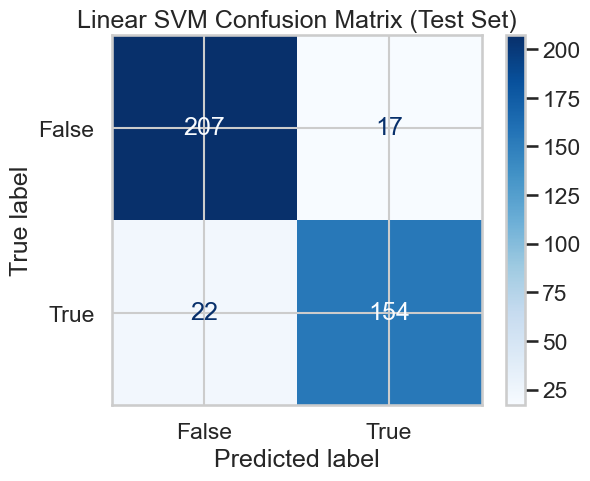

In [23]:
best_idx = gridsearch_linear.best_index_

print(f"Best Linear SVM Parameters: {gridsearch_linear.best_params_}")
print(f" Best CV Accuracy: {gridsearch_linear.best_score_:.4f}")

y_pred_linear = gridsearch_linear.predict(x_test)


for metric in scoring_metrics:
    mean_score = gridsearch_linear.cv_results_[f'mean_test_{metric}'][best_idx]
    std_score = gridsearch_linear.cv_results_[f'std_test_{metric}'][best_idx]
    print(f"CV mean {metric}: {mean_score:.4f} ± {std_score:.4f}")


print(classification_report(y_test_ravel, y_pred_linear))

# Confusion matrix
cm_linear = confusion_matrix(y_test_ravel, y_pred_linear)
disp_linear = ConfusionMatrixDisplay(
    confusion_matrix=cm_linear, display_labels=gridsearch_linear.classes_
)
disp_linear.plot(cmap=plt.cm.Blues)
plt.title("Linear SVM Confusion Matrix (Test Set)")
plt.show()



## Model 2: RBF-Kernel SVM with Cross-Validation

Now that we can test a non-linear SVM uwsing the RBF kernel. We will now search
the best combination of `C` and `gamma`.

In [24]:
pipeline_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel='rbf', random_state=42))
])

param_grid_rbf = {
    "svm__C": [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],
    "svm__gamma": ['scale', 'auto', 0.05, 0.1, 0.15, 0.2]
}

scoring_metrics = ['accuracy', 'f1_macro', 'roc_auc']

gridsearch_rbf = GridSearchCV(
    pipeline_rbf,
    param_grid_rbf,
    cv=5,
    scoring=scoring_metrics,
    refit='accuracy',
    verbose=1,
    n_jobs=-1
)

gridsearch_rbf.fit(x_train, y_train_ravel)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'svm__C': [0.5, 1, ...], 'svm__gamma': ['scale', 'auto', ...]}"
,scoring,"['accuracy', 'f1_macro', ...]"
,n_jobs,-1
,refit,'accuracy'
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


### 4.1 RBF SVM Results

We can now evaluate the best-found RBF model on the held-out test set

Best RBF SVM Parameters: {'svm__C': 4.5, 'svm__gamma': 0.2}
Best CV Accuracy: 0.9600
CV mean accuracy: 0.9600 ± 0.0124
CV mean f1_macro: 0.9594 ± 0.0127
CV mean roc_auc: 0.9935 ± 0.0015
              precision    recall  f1-score   support

       False       0.92      0.98      0.95       224
        True       0.97      0.89      0.93       176

    accuracy                           0.94       400
   macro avg       0.94      0.93      0.94       400
weighted avg       0.94      0.94      0.94       400



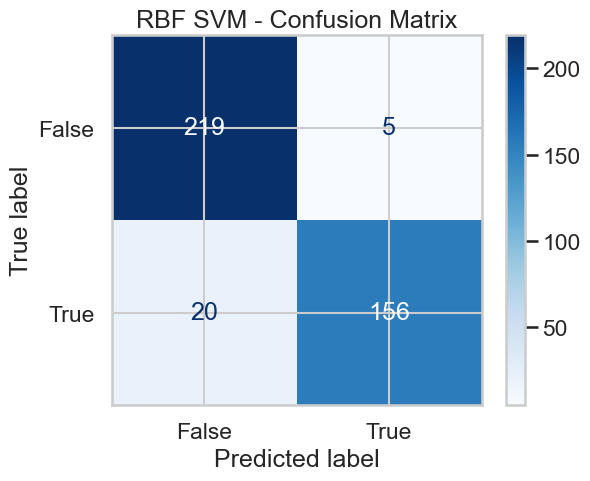

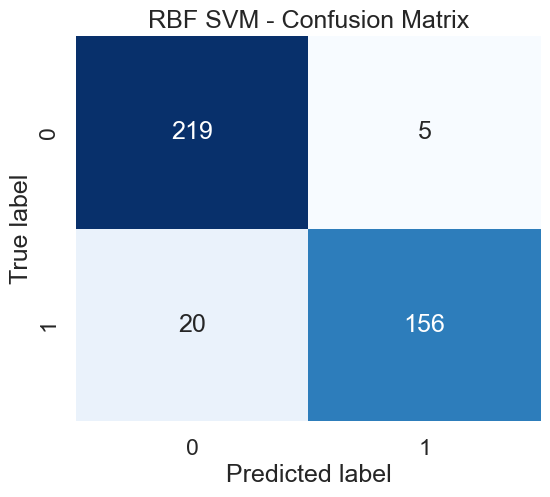

Best params: {'svm__C': 4.5, 'svm__gamma': 0.2}
CV mean accuracy:  0.96 ± 0.012405895775799498
CV mean f1_macro:   0.9594079725509621 ± 0.012671620569191057
CV mean roc_auc:    0.9934585618628764 ± 0.0014795228683369425


In [25]:
print(f"Best RBF SVM Parameters: {gridsearch_rbf.best_params_}")
print(f"Best CV Accuracy: {gridsearch_rbf.best_score_:.4f}")

best_idx = gridsearch_rbf.best_index_
y_pred_rbf = gridsearch_rbf.predict(x_test)


for metric in scoring_metrics:
    mean_score = gridsearch_rbf.cv_results_[f'mean_test_{metric}'][best_idx]
    std_score = gridsearch_rbf.cv_results_[f'std_test_{metric}'][best_idx]
    print(f"CV mean {metric}: {mean_score:.4f} ± {std_score:.4f}")


print(classification_report(y_test_ravel, y_pred_rbf))

# Confusion matrix
cm_rbf = confusion_matrix(y_test_ravel, y_pred_rbf)
disp_rbf = ConfusionMatrixDisplay(
    confusion_matrix=cm_rbf , display_labels=gridsearch_rbf.classes_
)
disp_rbf.plot(cmap=plt.cm.Blues)
plt.title("RBF SVM - Confusion Matrix")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test_ravel, y_pred_rbf), annot=True, cmap="Blues",
            fmt="d", cbar=False)
plt.title('RBF SVM - Confusion Matrix')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("./report/img/SVMConfusion.png")
plt.show()



best_idx = gridsearch_rbf.best_index_
print("Best params:", gridsearch_rbf.best_params_)
print("CV mean accuracy: ", gridsearch_rbf.cv_results_['mean_test_accuracy'][best_idx],
      "±", gridsearch_rbf.cv_results_['std_test_accuracy'][best_idx])
print("CV mean f1_macro:  ", gridsearch_rbf.cv_results_['mean_test_f1_macro'][best_idx],
      "±", gridsearch_rbf.cv_results_['std_test_f1_macro'][best_idx])
print("CV mean roc_auc:   ", gridsearch_rbf.cv_results_['mean_test_roc_auc'][best_idx],
      "±", gridsearch_rbf.cv_results_['std_test_roc_auc'][best_idx])
